# Online Learning Project
## [Paper] "A Tutorial on Conformal Prediction" by Glenn Shafer and Vladimir Vovk

In this paper, the authors present a novel method for evualuating machine learning model's accuracy in an online setting. Given a desired level $\epsilon$, the method constructs a confidence region $\Gamma^\epsilon$ for the predicted value that has at least a $1 - \epsilon$ probability of including the true value.

In this notebook we will implement the conformal prediction algorithm for both **classification** and **regression** and test it on some widely used datasets.

#### Some imports and global variables :

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [91]:
import pandas as pd
from scipy import stats

from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

In [4]:
np.random.seed(0)

The only hypothesis we need to use conformal prediction is that the samples of the training data are exchangeable. In the particular case were the samples are assumed to be i.i.d, this is obviously verified.

## Conformal Algorithm using old examples alone

Let's generate some random binomial i.i.d values :

In [5]:
n_trials = 5
n_samples = 30

samples = np.random.binomial(n=n_trials, p=1/3, size=n_samples)

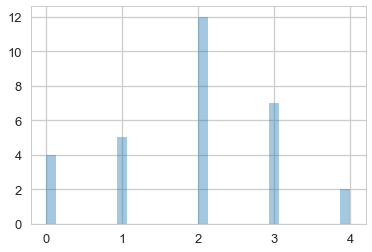

In [6]:
sns.distplot(samples, kde=False, bins=n_samples)

In [11]:
def nonconformity_measure(previous_values, new_value):
    estimation_from_old_examples = np.sum(previous_values) + new_value
    estimation_from_old_examples /= (len(previous_values) + 1.)
    return np.abs(estimation_from_old_examples - new_value)

def conformal_algorithm_from_old_examples(non_conformity_measure, previous_examples, new_example):
    n = len(previous_examples) + 1
    examples = list(previous_examples) + [new_example]

    alphas = []
    for i in range(n):
        alphas.append(non_conformity_measure(examples[:i] + examples[i+1:], examples[i]))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p

In [12]:
possible_values = range(n_trials + 1)

conformity_measures = []
for value in possible_values:
    p = conformal_algorithm_from_old_examples(nonconformity_measure, samples, value)
    conformity_measures.append(p)

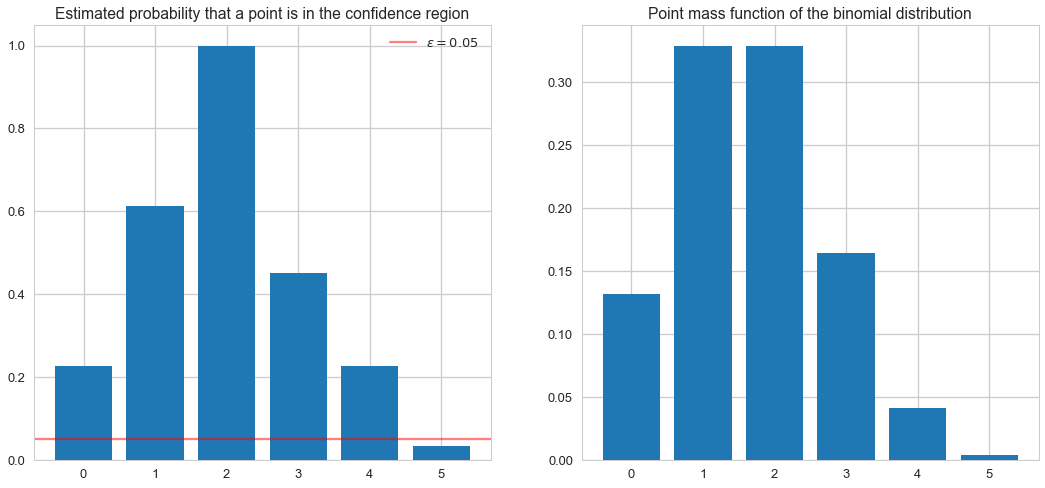

In [13]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.title("Estimated probability that a point is in the confidence region")
plt.bar(possible_values, conformity_measures)
plt.axhline(0.05, label="$\\epsilon = 0.05$", alpha=0.5, color='red')
plt.legend()
plt.subplot(122)
plt.title("Point mass function of the binomial distribution")
plt.bar(possible_values, stats.binom(n=n_trials, p=1/3).pmf(list(possible_values)))
plt.show()

Here, the confidence region would be $\{0, 1, 2, 3, 4\}$ as the score for $5$ is lower than 0.05.

## Conformal Algorithm using a new object
### Classification - Iris Dataset

In [105]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [106]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [107]:
def nonconformity_measure(bag_features, bag_targets, features, target):

    # Compute distances to :
    closest_same_category = min([np.linalg.norm(features - x, ord=2)
                                 for x, y in zip(bag_features, bag_targets) if y==target])
    closest_different_category = min([np.linalg.norm(features - x, ord=2)
                                      for x, y in zip(bag_features, bag_targets) if y!=target])
    
    measure = closest_same_category / closest_different_category
    return measure

def conformal_algorithm_using_new_object(nonconformity_measure, bag_features, bag_targets, features, value):
    n = len(bag_features) + 1
    
    X = list(bag_features) + [features]
    y = list(bag_targets) + [value]

    alphas = []
    for i in range(n):
        alphas.append(nonconformity_measure(
            X[:i] + X[i+1:], y[:i] + y[i+1:], X[i], y[i]
        ))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p

In [112]:
from tqdm import tqdm

epsilon = 0.05

hits = []
hits_model = []
for x, y in tqdm(zip(X_test, y_test)):
    confidence_region = []
    for c in set(y_train):
        score = conformal_algorithm_using_new_object(nonconformity_measure, X_train, y_train, x, c)
        if score > epsilon:
            confidence_region.append(c)
    hits.append(y in confidence_region)
    y_predicted = model.predict([x])[0]
    hits_model.append(y_predicted in confidence_region)

50it [00:12,  4.09it/s]


In [113]:
np.mean(hits)

0.96

In [114]:
np.mean(hits_model)

0.98

## Conformal Algorithm using a new object
### Regression

In [115]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [116]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [122]:
def nonconformity_measure(bag_features, bag_targets, features, target):
    estimation_from_old_examples = model.predict([features])[0]
    return np.abs(estimation_from_old_examples - target)

def conformal_algorithm_using_new_object(nonconformity_measure, bag_features, bag_targets, features, value):
    n = len(bag_features) + 1
    
    X = list(bag_features) + [features]
    y = list(bag_targets) + [value]

    alphas = []
    for i in range(n):
        alphas.append(nonconformity_measure(
            X[:i] + X[i+1:], y[:i] + y[i+1:], X[i], y[i]
        ))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p

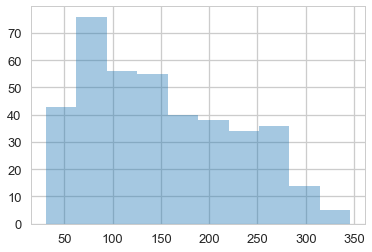

In [123]:
sns.distplot(y_train, kde=False)

In [134]:
from tqdm import tqdm

epsilon = 0.05

hits = []
hits_model = []
for x, y in tqdm(zip(X_test, y_test)):
    confidence_region = []
    values_space = np.linspace(0, 400, 10)
    for v in values_space:
        score = conformal_algorithm_using_new_object(nonconformity_measure, X_train, y_train, x, v)
        if score > epsilon:
            confidence_region.append(v)
    hits.append((y > min(confidence_region)) & (y < max(confidence_region)))
    y_predicted = model.predict([x])[0]
    hits_model.append((y_predicted > min(confidence_region)) & (y_predicted < max(confidence_region)))

45it [00:20,  2.18it/s]


In [135]:
np.mean(hits)

0.35555555555555557

In [136]:
np.mean(hits_model)

1.0